In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq

import muon as mu

import warnings
warnings.filterwarnings('ignore')


import seaborn as sns
import matplotlib.pyplot as plt
import plotnine as p9
from adjustText import adjust_text

from scipy.stats import ttest_rel

/home/dbdimitrov/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = os.path.join('..','..', 'data', 'sma')
slides = pd.read_csv(os.path.join(path, "sma_meta.csv"), index_col=0).index

In [268]:
palette = {'Intact': '#1f77b4', 'Lesioned': '#F7671A'}
views = {'receptor': 'Receptors', 'ct':'Cell types'}
view_palette = {"Receptors":"#008B8B", "Cell types":"#a11838"}

In [4]:
target_metrics = pd.read_csv(os.path.join('results', "target_metrics.csv"), index_col=None)
interactions = pd.read_csv(os.path.join('results', "interactions.csv"), index_col=None)
# prettify
target_metrics['intra_group'] = target_metrics['intra_group'].str.capitalize()
target_metrics.rename(columns=views, inplace=True)
target_metrics.head()
interactions['view'] = interactions['view'].replace(views)

In [195]:
mdata = mu.read_h5mu("results/B1_local.h5mu")

## Visualize

In [73]:
targets = target_metrics.groupby(['target', 'intra_group']).agg({"gain_R2":'mean'}).sort_values("gain_R2", ascending=False).reset_index()
top_targets = targets['target'].unique()[0:10]
# as categorical with levels from targets
target_metrics['target'] = pd.Categorical(target_metrics['target'], categories=targets['target'].unique())
metrics = target_metrics[target_metrics['target'].isin(top_targets)]
metrics['target'] = pd.Categorical(metrics['target'], categories=top_targets)

In [190]:
def plot_r2(metrics, ax):
    data = metrics[metrics['target']=='Dopamine']
    data['target'] = pd.Categorical(data['target'], categories=['Dopamine'])

    # Create the violin plot with an alpha of 0.5
    sns.violinplot(x='target', y='gain_R2', hue='intra_group', data=data, palette=palette, ax=ax)

    # Add the dots using stripplot
    sns.stripplot(x='target', y='gain_R2', hue='intra_group', data=data, dodge=True, jitter=True, size=3, palette=palette, ax=ax)

    # Customizing the plot
    ax.set_xlabel('')
    ax.set_ylabel('R2')
    ax.set_ylim(0, 1)
    sns.despine(ax=ax)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend = ax.legend(handles[0:2], labels[0:2], fontsize='x-large')
    
    # increase all fontsizes
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize('x-large')

In [191]:
def plot_contrib(metrics, ax):
    targets = ['Dopamine'] # , '3-MT'
    data = metrics[((metrics['target'].isin(targets)) & (metrics['intra_group']=="Intact"))]
    data['target'] = pd.Categorical(data['target'], categories=['Dopamine'])
    data = data.melt(id_vars=['target', 'intra_group'], value_vars=views.values(), var_name='View', value_name='Contribution')
    data['target'] = pd.Categorical(data['target'], categories=targets)

    # unstacked barplot, with a median
    sns.barplot(data=data, x='target', y='Contribution', hue='View', palette=view_palette, ci=95, errwidth=2, ax=ax)
    ax.set_title("")
    ax.set_xlabel("")
    ax.get_legend().remove()
    
    # increase all fontsizes
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize('xx-large')

In [192]:
def plot_interactions(interactions, ax=None):
    dop_ints = interactions[interactions['target']=='Dopamine'].copy()
    # predictors with highest importances
    dop_ints = (dop_ints[dop_ints['intra_group']=='intact'].
                groupby(['target', 'predictor', 'view']).
                # agg by mean and count
                agg({"importances":'median', 'slide':'count'}).
                rename(columns={'slide':'count'}).
                reset_index()
                )
    
    dop_ints['rank'] = dop_ints.groupby('target')['importances'].rank(ascending=False)
    dop_ints['View'] = dop_ints['view']
    
    # Check if ax is provided, if not use plt.gca()
    if ax is None:
        ax = plt.gca()

    # Create the scatter plot on the provided ax
    sns.scatterplot(x='rank', y='importances', palette=view_palette, hue='View', data=dop_ints, ax=ax, s=20)

    # Label the top 3 interactions
    top3 = dop_ints.nlargest(3, 'importances')
    texts = []
    for x, y, label in zip(top3['rank'], top3['importances'], top3['predictor']):
        text = ax.text(x, y, label, fontsize='xx-large', ha='left', va='center')
        texts.append(text)

    # Use adjust_text
    adjust_text(texts, ax=ax, force_pull=(-0.1, 0.2), arrowprops=dict(arrowstyle="<-", color='grey', lw=1.5))

    # Add labels and a title
    ax.set_xlabel('Rank')
    ax.set_ylabel('Importance')

    # Increase all fontsizes
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize('xx-large')
        
    # legend to xx-large
    ax.legend(fontsize='xx-large')


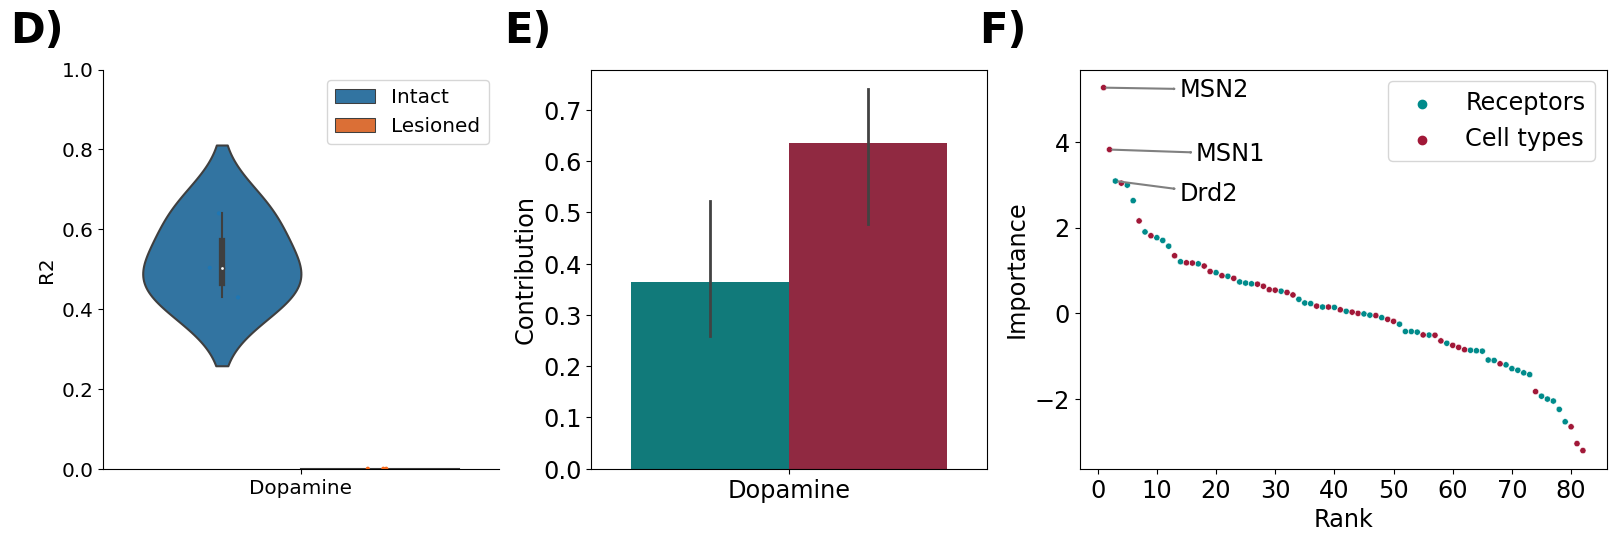

In [196]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create a figure
fig = plt.figure(figsize=(16, 5))

# Define GridSpec for 2 rows and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[1.5, 1.5, 2])

# Create subplots for the first row with different sizes
ax0 = plt.subplot(gs[0, 0])  # Smaller subplot
ax1 = plt.subplot(gs[0, 1])  # Larger subplot
ax2 = plt.subplot(gs[0, 2])  # Larger subplot

# Now you can use your function to plot in these subplots
plot_r2(metrics, ax0)  # For the first subplot in the first row
plot_contrib(metrics, ax1)  # For the second subplot in the first row
plot_interactions(interactions, ax2)  # For the third subplot in the first row
plt.tight_layout()

# add D), E), F) labels
labs = ['D)', 'E)', 'F)']
for i, ax in enumerate([ax0, ax1, ax2]):
    ax.text(-0.1, 1.15, labs[i], transform=ax.transAxes, fontsize=30, fontweight='bold', va='top', ha='right')

# Show the plot
plt.show()


In [236]:
mdata.mod['lr'].obs['Category'] = mdata.mod['lr'][:, 'Dopamine^Drd2'].layers['cats'].A.flatten()
# if 1 Positive, -1 Negative, 0 Neither 
mdata.mod['lr'].obs['Category'] = mdata.mod['lr'].obs['Category'].replace({1:'Positive', -1:'Negative', 0:'Neither'})

In [269]:
from matplotlib.colors import ListedColormap
cat_palette = ListedColormap(sns.color_palette(['#1f77b4', 'lightgray', '#e62e00']).as_hex())

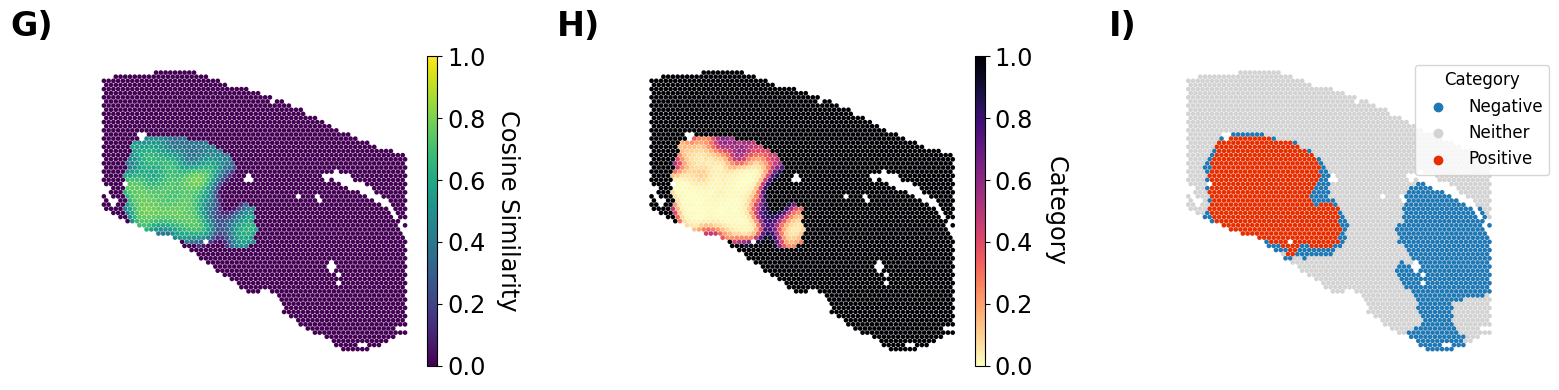

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

sq.pl.spatial_scatter(mdata.mod['lr'], color=['Dopamine^Drd2'], size=1.5, cmap='viridis', vmax=1, vmin=0, ax=axes[0], img=False, frameon=False, title='')
# keep only 1,0, and -1 ticks on colorbar
# cbar = axes[1].collections[0].colorbar
# cbar.set_ticks([-1, 0, 1])
sq.pl.spatial_scatter(mdata.mod['lr'], color=['Dopamine^Drd2'], layer='pvals', size=1.5, cmap='magma_r', vmax=1, ax=axes[1], img=False, frameon=False, title='')
sq.pl.spatial_scatter(mdata.mod['lr'], color=['Category'], palette=cat_palette, size=1.5, vmax=1, vmin=-1, ax=axes[2], img=False, frameon=False, title='')

labels = ["Cosine Similarity", "Category"]

# Loop over the axes and set the colorbar labels
for ax, label in zip(axes.flat[0:2], labels):  # ax.flat if ax is a 2D array
    cbar = ax.collections[0].colorbar
    cbar.set_label(label, rotation=270, labelpad=25, fontsize='xx-large')
    cbar.ax.tick_params(labelsize='xx-large')

# set legend labels to large
axes[2].legend(fontsize='large', loc='upper right', bbox_to_anchor=(1.15, 1.0), title='Category', title_fontsize='large')

labs = ['G)', 'H)', 'I)']
for i, ax in enumerate(axes):
    ax.text(-0.1, 1.15, labs[i], transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='right')


# reduce wspace
fig.subplots_adjust(wspace=0)
fig.tight_layout()
plt.show()

# fig.savefig("figures/dopamine_drd2.pdf")

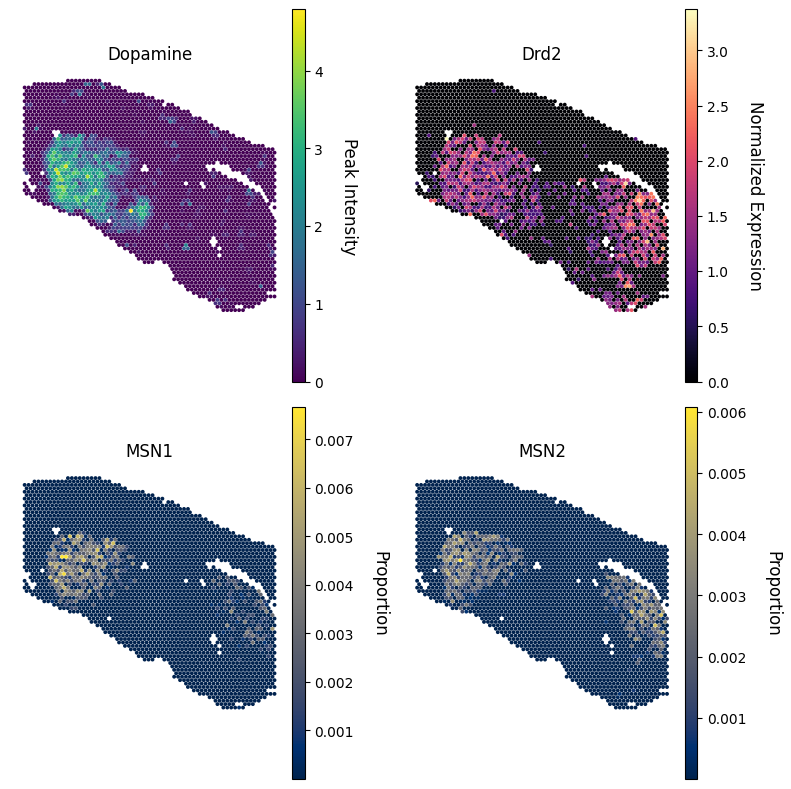

In [135]:

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
sq.pl.spatial_scatter(mdata.mod['msi'], color=['Dopamine'], size=1.5, cmap="viridis", ax=ax[0, 0], img=False, frameon=False)
sq.pl.spatial_scatter(mdata.mod['rna'], color=['Drd2'], size=1.5, cmap='magma', ax=ax[0, 1], img=False, frameon=False)
sq.pl.spatial_scatter(mdata.mod['deconv'], color=['MSN1'], size=1.5, cmap="cividis", ax=ax[1, 0], img=False, frameon=False)
sq.pl.spatial_scatter(mdata.mod['deconv'], color=['MSN2'], size=1.5, cmap='cividis', ax=ax[1, 1], img=False, frameon=False)

labels = ["Peak Intensity", "Normalized Expression", "Proportion", "Proportion"]

# Loop over the axes and set the colorbar labels
for ax, label in zip(ax.flat, labels):  # ax.flat if ax is a 2D array
    cbar = ax.collections[0].colorbar
    # reduce height of colorbar
    box = cbar.ax.get_position()
    cbar.set_label(label, rotation=270, labelpad=25, fontsize='large')

plt.tight_layout()

SF A)

In [264]:
# Assuming 'filtered_data' is your DataFrame after filtering out the zero-only boxplots
plt.figure(figsize=(6, 6))  # Adjust the size to accommodate your number of categories

# Create the violin plot with an alpha of 0.5
sns.violinplot(x='target', y='gain_R2', hue='intra_group', data=metrics, palette=palette)

# Add the dots using stripplot
sns.stripplot(x='target', y='gain_R2', hue='intra_group', data=metrics, dodge=True, jitter=True, size=3, palette=palette)

# Customizing the plot
plt.xticks(rotation=90)
plt.xlabel('Metabolite Peak')
plt.ylabel('R2')
plt.ylim(0, 1)
sns.despine()

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])


# Show the plot
plt.tight_layout()
plt.show()

KeyError: 'Intact'

<Figure size 600x600 with 0 Axes>

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


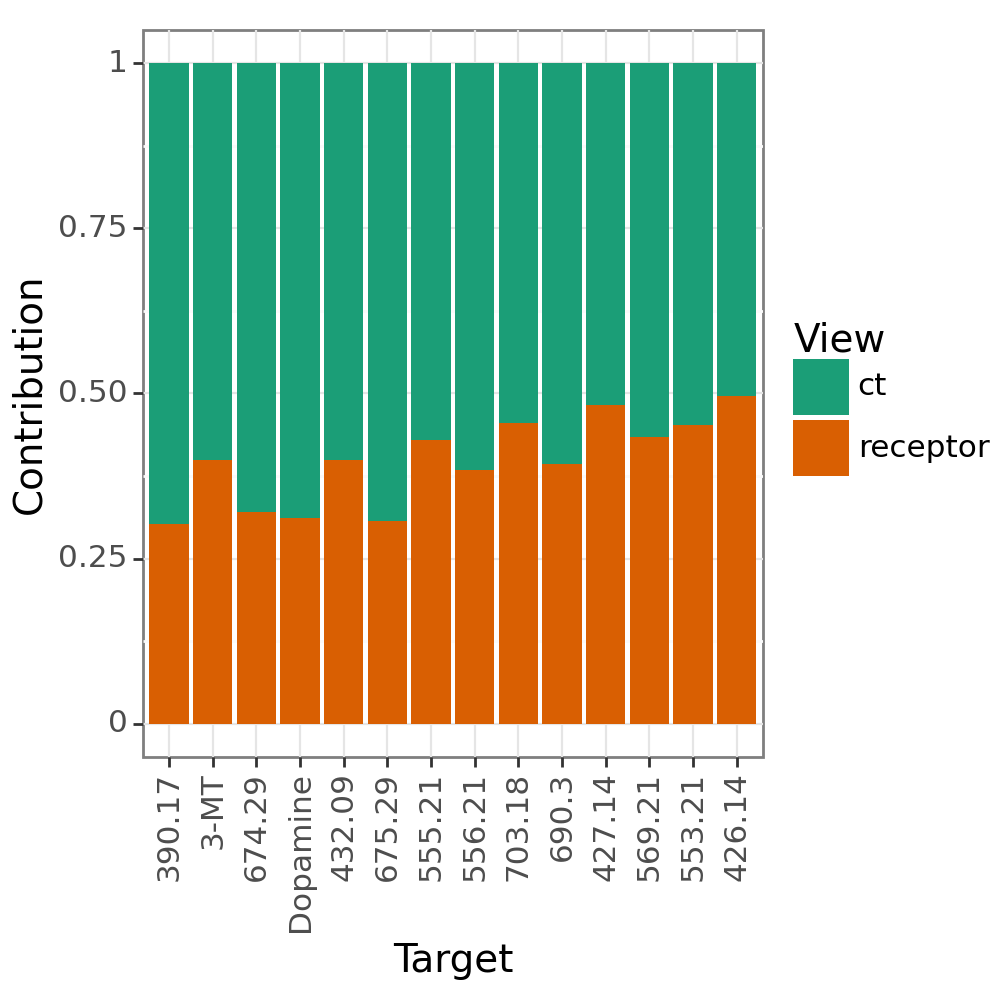

<Figure Size: (500 x 500)>

In [ ]:
li.pl.contributions(target_metrics=target_metrics, 
                    filter_fun=lambda x: bool((x['target'] in top_targets) * (x['intra_group']=='intact')),
                    view_names=['receptor', 'ct'],
                    aggregate_fun='median',
                    figure_size=(5, 5)
                    )

In [ ]:
dop_ints = interactions[interactions['target']=='Dopamine'].copy()
# predictors with highest importances
predictors = (dop_ints[dop_ints['intra_group']=='intact'].
              groupby(['target', 'predictor']).
              # agg by mean and count
              agg({"importances":'median', 'level_0':'count'}).
              rename(columns={'level_0':'count'}).
              reset_index()
              )
# detected in all 3 samples, NOTE: filter to top 10 predictors
predictors = predictors[predictors['count']==3].sort_values('importances', ascending=False)

In [ ]:
predictors.head(3)

,target,predictor,importances,count
50,Dopamine,MSN2,5.271267,3
49,Dopamine,MSN1,3.823600,3
18,Dopamine,Drd2,3.087695,3


In [ ]:
# rename to an abbreviation
dop_ints.loc[dop_ints['predictor']=='Subventricular zone radial glia-like cells', 'predictor'] = 'SVZGC'
dop_ints.loc[dop_ints['predictor']=='Oligodendrocytes', 'predictor'] = 'Oligo'
dop_ints = dop_ints[dop_ints['predictor'].isin(predictors['predictor'])].copy()

In [ ]:
pvals = pd.DataFrame(columns=['predictor', 'pval'])
for predictor in dop_ints['predictor'].unique():
    interaction_msk = ((interactions['predictor']==predictor) & (interactions['target']=='Dopamine'))
    group1 = interactions[interaction_msk & (interactions['intra_group']=='intact')].copy()
    group2 = interactions[interaction_msk & (interactions['intra_group']=='lesioned')].copy()
    tt = ttest_rel(group1['importances'], group2['importances'], alternative='greater')
    pvals.loc[len(pvals)] = [predictor, tt.pvalue]

In [ ]:
pvals['fdr'] = dc.p_adjust_fdr(pvals['pval'].values)

In [ ]:
pvals.set_index('predictor', inplace=True)

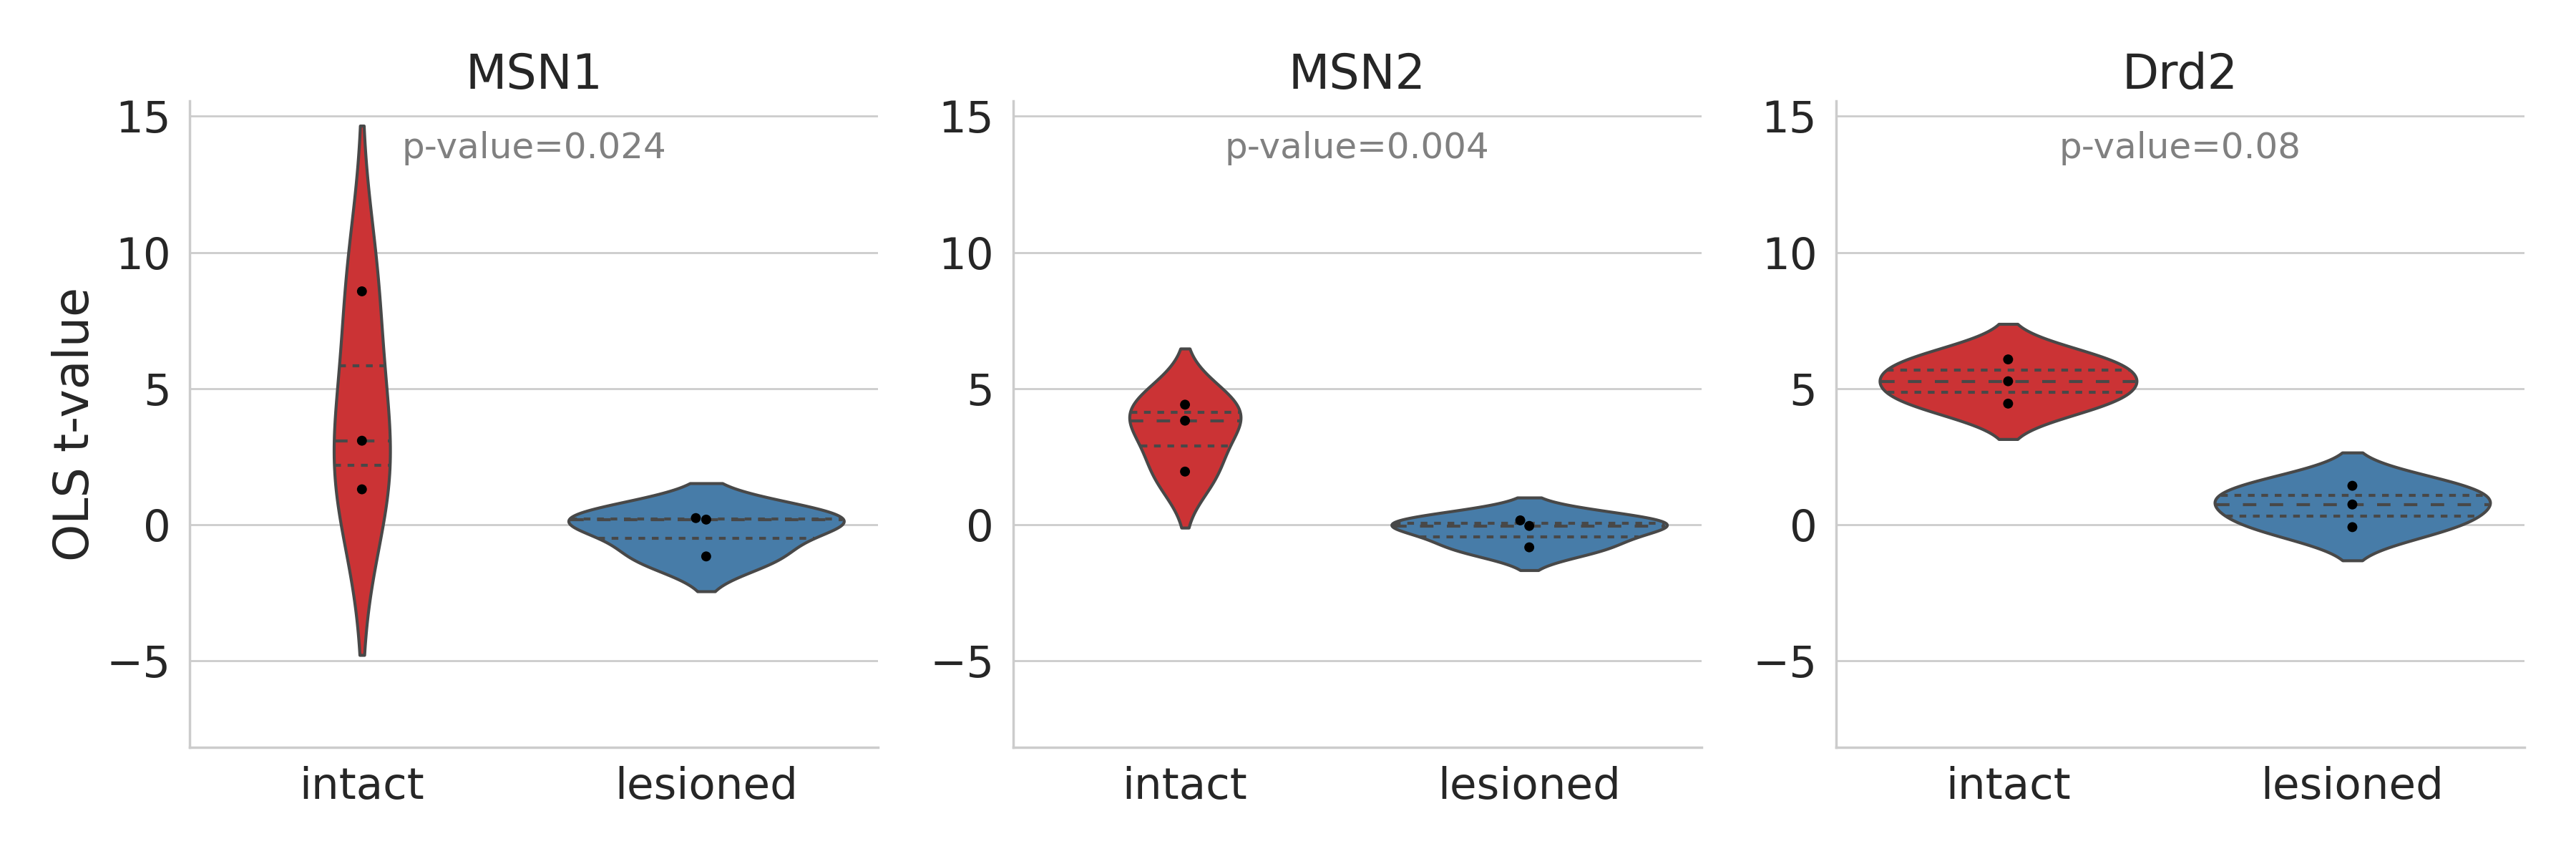

In [ ]:
preds = ["MSN1", "MSN2", "Drd2"]
df = dop_ints[dop_ints['predictor'].isin(preds)]

# Set the style to seaborn for better aesthetics
sns.set(style="whitegrid", font_scale=2)

# Create subplots with facets
g = sns.FacetGrid(df, col="predictor", col_wrap=3, height=6, sharey=False, ylim=(df['importances'].min() - 7, df['importances'].max() + 7))
g.map_dataframe(sns.violinplot, x='intra_group', y='importances', split=True, inner='quart', alpha=0.6, color='intra_group', palette='Set1')
g.map_dataframe(sns.swarmplot, x='intra_group', y='importances', color='black')

# Add text for t-test result
for pred, ax in zip(preds, g.axes.flat):
    pval_label = f'p-value={round(pvals.loc[pred]["pval"], 3)}'
    ax.text(0.5, 0.9, pval_label, ha='center', va='bottom', transform=ax.transAxes, color='gray', size=18)
    ax.set_title(pred)

# Set labels and title
g.set_axis_labels("Predictor", "OLS t-value")

# Remove x axis labels
plt.setp(g.axes.flat, xlabel='')

# Adjust layout
plt.tight_layout()

plt.savefig("dopamine.pdf")
plt.show()
